Loading existing TF-IDF vectorizer...
Loading existing models...
Evaluating Logistic Regression...
Logistic Regression Accuracy: 0.9372, F1: 0.7346, AUC: 0.9675
Evaluating Random Forest...
Random Forest Accuracy: 0.9450, F1: 0.6909, AUC: 0.9472
Evaluating Decision Tree...
Decision Tree Accuracy: 0.9098, F1: 0.6244, AUC: 0.8381
Evaluating Naive Bayes...
Naive Bayes Accuracy: 0.9461, F1: 0.6593, AUC: 0.9526
Evaluating SVC...
SVC Accuracy: 0.9333, F1: 0.7157, AUC: 0.9575
Training new voting classifier...


/home/bash/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Voting Classifier Accuracy: 0.9569, F1: 0.7745, AUC: 0.9669
Confusion Matrix for Logistic Regression


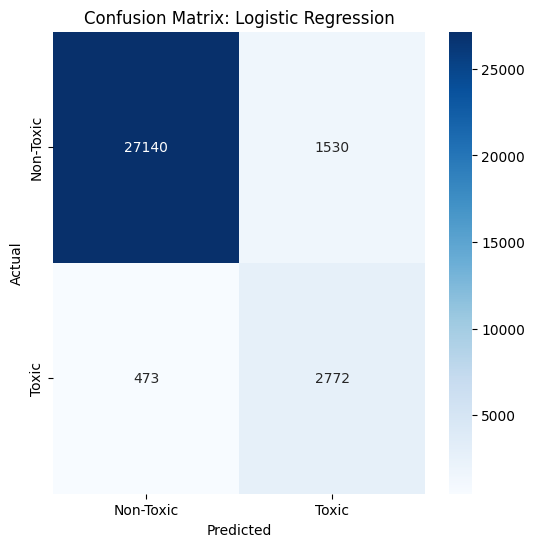

Confusion Matrix for Random Forest


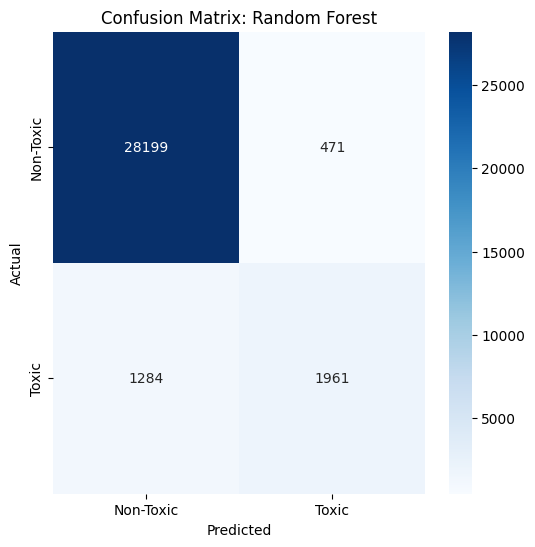

Confusion Matrix for Decision Tree


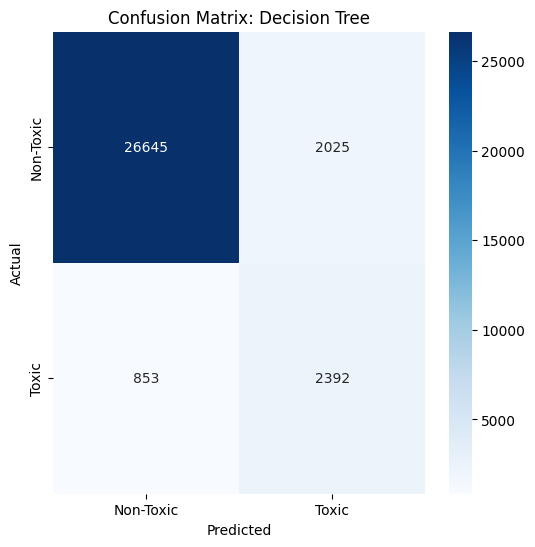

Confusion Matrix for Naive Bayes


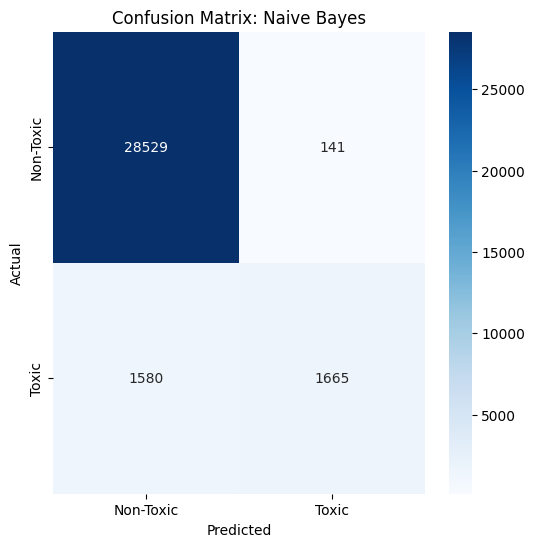

Confusion Matrix for SVC


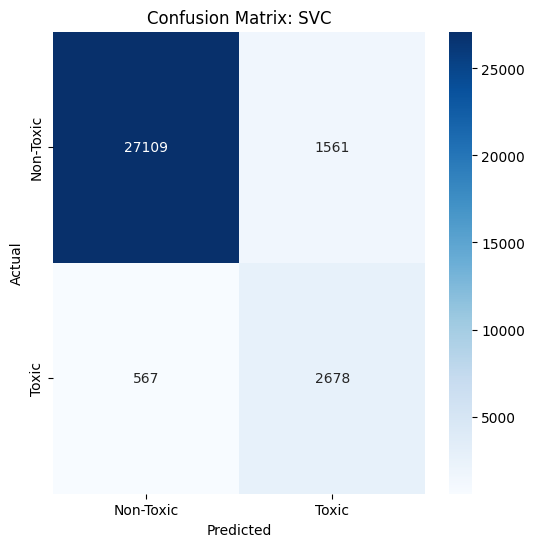

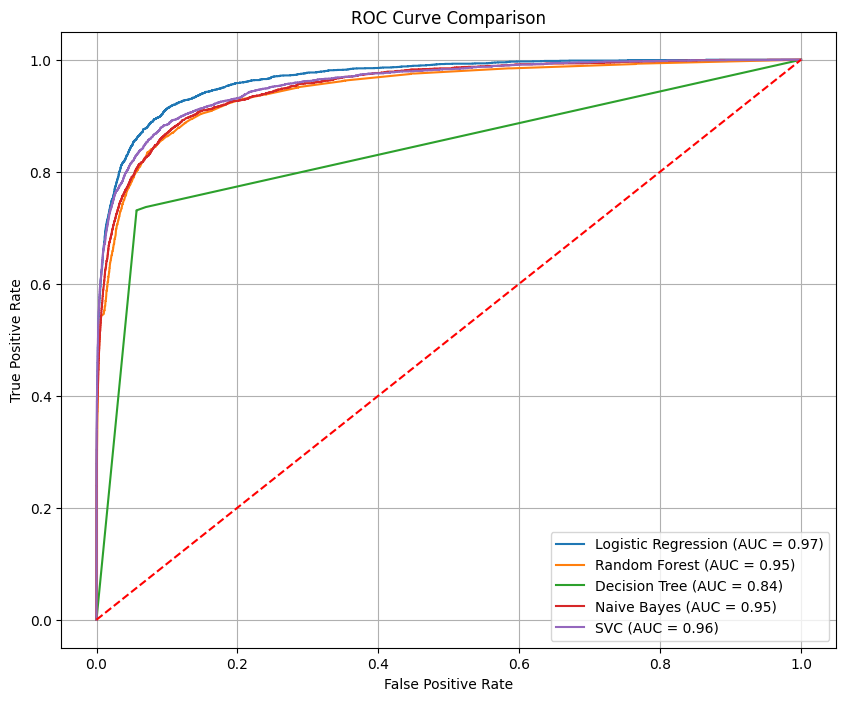

In [14]:
# %% [Imports]
from sklearn.svm import SVC
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

# %% [Data Loading]
df = pd.read_csv('train.csv')  # Replace with actual path to dataset

# Combine all toxic categories into one binary column
df['target'] = (df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1) > 0).astype(int)

# %% [Text Preprocessing]
import re

def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.lower()
    return text

df['comment_text'] = df['comment_text'].apply(preprocess_text)

# %% [Feature Extraction and Data Split]
# Check if saved vectorizer exists
if os.path.exists('tfidf_vectorizer.pkl'):
    print("Loading existing TF-IDF vectorizer...")
    tfidf = joblib.load('tfidf_vectorizer.pkl')
    X = tfidf.transform(df['comment_text'])
else:
    print("Training new TF-IDF vectorizer...")
    tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1, 2), stop_words='english')
    X = tfidf.fit_transform(df['comment_text'])
    joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

y = df['target']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# %% [Class Weights]
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

# %% [Models]
# Define base models
base_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=42),
    "Naive Bayes": MultinomialNB(),
    "SVC": LinearSVC(class_weight='balanced', max_iter=10000, random_state=42),
}

# Check if saved models exist
if os.path.exists('all_models.pkl'):
    print("Loading existing models...")
    models = joblib.load('all_models.pkl')
else:
    print("Training new models...")
    models = base_models.copy()
    # Train models and save them
    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train, y_train)
    joblib.dump(models, 'all_models.pkl')

# %% [Evaluate Models]
results = {}
for name, model in models.items():
    print(f"Evaluating {name}...")
    y_pred = model.predict(X_test)
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.decision_function(X_test) if hasattr(model, "decision_function") else model.predict_proba(X_test)[:, 1])
    
    print(f"{name} Accuracy: {accuracy:.4f}, F1: {f1:.4f}, AUC: {roc_auc:.4f}")
    results[name] = {"Accuracy": accuracy, "F1": f1, "AUC": roc_auc}

# %% [Voting Classifier]
# Check if voting classifier exists
if os.path.exists('voting_classifier.pkl'):
    print("Loading existing voting classifier...")
    voting_clf = joblib.load('voting_classifier.pkl')
else:
    print("Training new voting classifier...")
    voting_clf = VotingClassifier(estimators=[
        ('lr', models['Logistic Regression']),
        ('rf', models['Random Forest']),
        ('dt', models['Decision Tree']),
        ('nb', models['Naive Bayes']),
        ('svc', SVC(class_weight='balanced', probability=True, max_iter=10000, random_state=42))
    ], voting='soft')
    voting_clf.fit(X_train, y_train)
    joblib.dump(voting_clf, 'voting_classifier.pkl')

y_pred = voting_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, voting_clf.predict_proba(X_test)[:, 1])
results["Voting Classifier"] = {"Accuracy": accuracy, "F1": f1, "AUC": roc_auc}

print(f"Voting Classifier Accuracy: {accuracy:.4f}, F1: {f1:.4f}, AUC: {roc_auc:.4f}")

# %% [Confusion Matrix]
def plot_confusion_matrix(model_name, y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Toxic', 'Toxic'], yticklabels=['Non-Toxic', 'Toxic'])
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Plot for each model
for name, model in models.items():
    print(f"Confusion Matrix for {name}")
    y_pred = model.predict(X_test)
    plot_confusion_matrix(name, y_test, y_pred)

# %% [ROC Curve]
def plot_roc_curve(models, X_test, y_test):
    plt.figure(figsize=(10, 8))
    for name, model in models.items():
        if hasattr(model, "decision_function"):
            y_scores = model.decision_function(X_test)
        else:
            y_scores = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_scores)
        auc_score = roc_auc_score(y_test, y_scores)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.2f})")
    
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Random chance line
    plt.title('ROC Curve Comparison')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid()
    plt.show()

# Plot ROC curves
plot_roc_curve(models, X_test, y_test)

In [20]:
import pandas as pd
import joblib
import re

# Function for text preprocessing (same as in training)
def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.lower()
    return text

# Load test data
print("Loading test data...")
test_df = pd.read_csv('test.csv')  # Replace with actual path to test.csv

# Preprocess the test comments
print("Preprocessing test comments...")
test_df['comment_text'] = test_df['comment_text'].apply(preprocess_text)

# Load the saved TF-IDF vectorizer and voting classifier
print("Loading saved models...")
try:
    tfidf = joblib.load('tfidf_vectorizer.pkl')
    voting_clf = joblib.load('voting_classifier.pkl')
except FileNotFoundError:
    raise FileNotFoundError("Required model files not found. Please ensure both 'tfidf_vectorizer.pkl' and 'voting_classifier.pkl' exist.")

# Transform test data using the loaded vectorizer
print("Transforming test data...")
X_test = tfidf.transform(test_df['comment_text'])

# Make predictions
print("Making predictions...")
predictions_proba = voting_clf.predict_proba(X_test)
predictions = voting_clf.predict(X_test)

# Create results DataFrame
results_df = pd.DataFrame({
    'id': test_df['id'],
    'comment_text': test_df['comment_text'],
    'toxic_probability': predictions_proba[:, 1],
    'prediction': predictions
})

# Add prediction labels
results_df['prediction_label'] = results_df['prediction'].map({0: 'Non-Toxic', 1: 'Toxic'})

# Save results
output_filename = 'toxic_predictions.csv'
print(f"Saving predictions to {output_filename}...")
results_df.to_csv(output_filename, index=False)

# Print summary statistics
print("\nPrediction Summary:")
print(f"Total comments processed: {len(results_df)}")
print(f"Predicted toxic comments: {results_df['prediction'].sum()}")
print(f"Predicted non-toxic comments: {len(results_df) - results_df['prediction'].sum()}")
print(f"\nResults have been saved to {output_filename}")

# Optional: Display the first few predictions
print("\nFirst few predictions:")
print(results_df[['comment_text', 'toxic_probability', 'prediction_label']].head())

Loading test data...
Preprocessing test comments...
Loading saved models...
Transforming test data...
Making predictions...
Saving predictions to toxic_predictions.csv...

Prediction Summary:
Total comments processed: 153164
Predicted toxic comments: 34688
Predicted non-toxic comments: 118476

Results have been saved to toxic_predictions.csv

First few predictions:
                                        comment_text  toxic_probability  \
0  yo bitch ja rule is more succesful then you ll...           0.967073   
1           from rfc the title is fine as it is imo            0.018409   
2                    sources zawe ashton on lapland            0.029235   
3   if you have a look back at the source the inf...           0.017992   
4          i don t anonymously edit articles at all            0.068492   

  prediction_label  
0            Toxic  
1        Non-Toxic  
2        Non-Toxic  
3        Non-Toxic  
4        Non-Toxic  
